# 模型训练

In [1]:
#  导入数据
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# 读取前1000行
# train_data = pd.read_csv('train_all.csv', nrows=1000)
# test_data = pd.read_csv('test_all.csv', nrows=1000)

# 读取全部数据
train_data = pd.read_csv('train_all.csv', nrows=None)
test_data = pd.read_csv('test_all.csv', nrows=None)

# 训练数据和测试数据处理
feature_columns = [col for col in train_data.columns if col not in ['user_id', 'label']]
train = train_data[feature_columns].values
test = test_data[feature_columns].values
target = train_data['label'].values


# folds = 5
# kf = KFold(n_splits=folds, shuffle=True, random_state=2021)

# for idx, (train_index, test_index) for enumerate(kf.split(ttain)):
#     train_x = train[train_index]
#     train_y = target[train_index]
#     test_x = test[test_index]
#     test_y = target[test_index]


# 切分数据
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_train.shape)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)


(156518, 230) (156518,)
(104346, 230) (156518,)


0.9387710118260403

In [2]:
# 简单验证
from sklearn.model_selection import cross_val_score

# clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
# clf = clf.fit(X_train, y_train)

scores = cross_val_score(clf, train, target, cv=5)
print(scores)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

[0.93885726 0.93885726 0.9388381  0.9388381  0.93885609]
Accuracy: 0.94 (+/- 0.00)


In [3]:
# F1值进行评价
"""
'micro':Calculate metrics globally by counting the total true positives, false negatives and false positives.
'micro':通过先计算总体的TP，FN和FP的数量，再计算F1
'macro':Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
'macro':分布计算每个类别的F1，然后做平均（各类别F1的权重相同）
"""

scores = cross_val_score(clf, train, target, cv=5, scoring='f1_macro')
print(scores)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

[0.48423227 0.48423227 0.48422718 0.48422718 0.48423196]
Accuracy: 0.48 (+/- 0.00)


In [4]:
# 交叉验证
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, train, target, cv=cv)

array([0.93870432, 0.93828265, 0.93956044, 0.94040378, 0.93763097])

In [5]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
for k, (train_index, test_index) in enumerate(kf.split(train)):
    x_train, x_test, y_train, y_test = train[train_index], train[test_index], target[train_index], target[test_index]
    clf = clf.fit(x_train, y_train)
    print(k, clf.score(x_test, y_test))

0 0.9395089414064746
1 0.9386272593103713
2 0.9374005711766623
3 0.9398539474440802
4 0.9388560913900177


In [6]:
# 分组切分数据
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)
for k, (train_index, test_index) in enumerate(kf.split(train, target)):
    x_train, x_test, y_train, y_test = train[train_index], train[test_index], target[train_index], target[test_index]
    clf = clf.fit(x_train, y_train)
    print(k, clf.score(x_test, y_test))

0 0.9388572633354417
1 0.9388572633354417
2 0.9388380963333525
3 0.9388380963333525
4 0.9388560913900177


In [7]:
# 模型调参
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.5, random_state=0)

# model
clf = RandomForestClassifier(n_jobs=-1)
tune_parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 5],
    'max_features': ['log2', 'sqrt', 'int'],
    'bootstrap': [True, False],
    'warm_start': [True, False],
}

scores = ['precision']
for score in scores:
    print('Tune hyper-parameters for %s' % score)
    print()

    clf = GridSearchCV(clf, tune_parameters, cv=5, scoring='%s_macro'  % score)
    clf.fit(X_train, y_train)
    print('Best parameters set found on development set:')
    print()
    print(clf.best_params_)
    print()
    print('Grid scores on development set:')
    print()
    mean = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(mean, stds, clf.cv_results_):
        print('%0.3f (+/-%0.03f) for %r' % (mean, std * 2, params))
        print()
        print('Detailed classification report:')
        print()
        print('The model is trained on the full develoment set.')
        print('The scores are computed on the full evaluation set.')
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

Tune hyper-parameters for precision

Best parameters set found on development set:

{'bootstrap': True, 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 50, 'warm_start': True}

Grid scores on development set:

0.469 (+/-0.000) for 'mean_fit_time'

Detailed classification report:

The model is trained on the full develoment set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    122462
         1.0       0.00      0.00      0.00      7970

    accuracy                           0.94    130432
   macro avg       0.47      0.50      0.48    130432
weighted avg       0.88      0.94      0.91    130432


0.469 (+/-0.000) for 'std_fit_time'

Detailed classification report:

The model is trained on the full develoment set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    122462


              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    122462
         1.0       0.00      0.00      0.00      7970

    accuracy                           0.94    130432
   macro avg       0.47      0.50      0.48    130432
weighted avg       0.88      0.94      0.91    130432


nan (+/-nan) for 'rank_test_score'

Detailed classification report:

The model is trained on the full develoment set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    122462
         1.0       0.00      0.00      0.00      7970

    accuracy                           0.94    130432
   macro avg       0.47      0.50      0.48    130432
weighted avg       0.88      0.94      0.91    130432




Confusion matrix, Without normaliation
[[61122    92]
 [ 3983    19]]
Confusion matrix normalization
[[1. 0.]
 [1. 0.]]


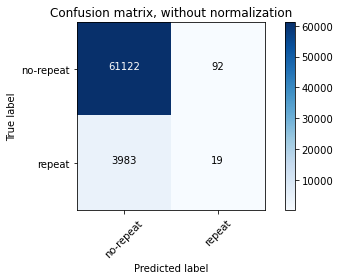

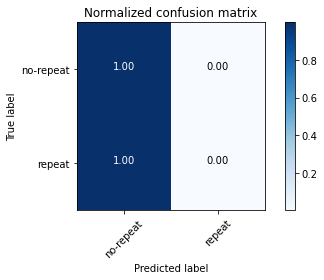

In [11]:

# 混淆矩阵
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# label_name
class_names = ['no-repeat', 'repeat']
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)
clf = RandomForestClassifier(n_jobs=-1)
y_pred = clf.fit(X_train, y_train).predict(X_test)

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix,
    Normalization can be applied by setting 'normalize=True'
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Confusion matrix normalization')
    else:
        print('Confusion matrix, Without normaliation')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plt.figure()

plot_confusion_matrix(cnf_matrix,
                      classes=class_names,
                      normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [13]:
# 逻辑回归模型
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
clf.score(X_test, y_test)

0.9386193572129539

In [15]:
# KNN 模型
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9386193572129539

In [16]:
# 高斯贝叶斯模型
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = GaussianNB().fit(X_train, y_train)
clf.score(X_test, y_test)

0.7291615554465162

In [17]:
# 决策树模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = DecisionTreeClassifier().fit(X_train, y_train)
clf.score(X_test, y_test)

0.8820074828263003

In [18]:
# Bagging模型
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = BaggingClassifier(base_estimator=KNeighborsClassifier(), max_samples=0.5, max_features=0.5).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9386346908734053

In [19]:
# 随机森林模型
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9365799803729146

In [20]:
# 极端森林模型
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9365799803729146

In [21]:
# AdaBoost模型
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)
clf.score(X_test, y_test)

0.938588689892051

In [22]:
# GBDT模型
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
X_train, X_test, y_train, y_test =  train_test_split(X, target, random_state=0)

clf = GradientBoostingClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9075226938174681

In [31]:
# 集成学习
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=0)
clf2 = RandomForestClassifier(n_estimators=100, random_state=0)
clf3 = GaussianNB()

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
for clf, label in zip([clf1, clf2, clf3, eclf],
                      ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X,y, cv=5, scoring='accuracy')
    print('Accuracy: %0.2f (+/-%0.2f) [%s]' % (scores.mean(), scores.std(), label) )



Accuracy: 0.94 (+/-0.00) [Logistic Regression]
Accuracy: 0.94 (+/-0.00) [Random Forest]
Accuracy: 0.73 (+/-0.00) [naive Bayes]
Accuracy: 0.94 (+/-0.00) [Ensemble]


In [41]:
# LightGBM
import lightgbm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X = scaler.fit_transform(train)

X_train, X_test, y_train, y_test = train_test_split(X, target,
                                                    test_size=0.4, random_state=0)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test,
                                                    test_size=0.5, random_state=0)

clf = lightgbm
train_matrix = clf.Dataset(X_train, label=y_train)
test_matrix = clf.Dataset(X_test, label=y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'min_child_weight': 1.5,
    'num_leaves': 2**5,
    'lambda_l2': 10,
    'subsample': 0.7,
    'collsample_bytree': 0.7,
    'collsample_bylevel': 0.7,
    'learn_rate': 0.03,
    'tree_method': 'exact',
    'seed': 2021,
    'num_class': 2,
    'silent': True
}

num_round = 10000
early_stopping_rounds = 100
model = clf.train(params,
                  train_matrix,
                  num_round,
                  valid_sets=test_matrix,
                  early_stopping_rounds=early_stopping_rounds)

pre = model.predict(X_valid, num_iteration=model.best_iteration)

[LightGBM] [Warning] Unknown parameter: collsample_bylevel
[LightGBM] [Warning] Unknown parameter: collsample_bytree
[LightGBM] [Warning] Unknown parameter: learn_rate
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: collsample_bylevel
[LightGBM] [Warning] Unknown parameter: collsample_bytree
[LightGBM] [Warning] Unknown parameter: learn_rate
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30916
[LightGBM] [Info] Number of data points in the train set: 156518, number of used features: 129
[LightGBM] [Warning] Unknown parameter: collsample_bylevel
[LightGBM] [Warning] Unknown parameter: collsamp

In [39]:
# XGB
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X = scaler.fit_transform(train)

X_train, X_test, y_train, y_test = train_test_split(X, target,
                                                    test_size=0.4, random_state=0)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test,
                                                    test_size=0.5, random_state=0)

clf = xgboost
train_matrix = clf.DMatrix(X_train, label=y_train, missing=-1)
test_matrix = clf.DMatrix(X_test, label=y_test, missing=-1)
z = clf.DMatrix(X_valid, label=y_valid, missing=-1)

params = {
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'gamma': 1,
    'min_child_weight': 1.5,
    'max_depth': 5,
    'lambda': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.7,
    'tree_method': 'exact',
    'seed': 2021,
    'num_class': 2
}

num_round = 10000
early_stopping_rounds=100
watchlist = [(train_matrix, 'train'), (test_matrix, 'eval')]

model = clf.train(params,
                  train_matrix,
                  num_boost_round=num_round,
                  evals=watchlist,
                  early_stopping_rounds=early_stopping_rounds)
pre = model.predict(z, ntree_limit=model.best_ntree_limit)

[0]	train-mlogloss:0.49575	eval-mlogloss:0.49549
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 100 rounds.
[1]	train-mlogloss:0.38952	eval-mlogloss:0.38916
[2]	train-mlogloss:0.32619	eval-mlogloss:0.32579
[3]	train-mlogloss:0.28690	eval-mlogloss:0.28648
[4]	train-mlogloss:0.26209	eval-mlogloss:0.26167
[5]	train-mlogloss:0.24653	eval-mlogloss:0.24617
[6]	train-mlogloss:0.23682	eval-mlogloss:0.23659
[7]	train-mlogloss:0.23104	eval-mlogloss:0.23094
[8]	train-mlogloss:0.22736	eval-mlogloss:0.22748
[9]	train-mlogloss:0.22524	eval-mlogloss:0.22562
[10]	train-mlogloss:0.22389	eval-mlogloss:0.22460
[11]	train-mlogloss:0.22305	eval-mlogloss:0.22401
[12]	train-mlogloss:0.22248	eval-mlogloss:0.22365
[13]	train-mlogloss:0.22202	eval-mlogloss:0.22349
[14]	train-mlogloss:0.22163	eval-mlogloss:0.22346
[15]	train-mlogloss:0.22138	eval-mlogloss:0.22346
[16]	train-mlogloss:0.22113	eval-mlogloss:0.22352
[17]	tra

In [45]:
# 封装自己的模型
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

class SBBTree():
    """
    SBBTree
    Stacking Bootstrap bagging
    """

    def __init__(self, params, stacking_num, bagging_num, bagging_test_size, num_boost_round, early_stopping_rounds):
        """
        Initialize the SBBTree
        :param params: lgm params
        :param stacking_num: k_folds num
        :param bagging_num: bootstrap num
        :param bagging_test_size: bootstrap sample rate
        :param num_boost_round: boost num
        :param early_stopping_rounds: early_stopping_rounds
        """
        self.params = params
        self.stacking_num =  stacking_num
        self.bagging_num = bagging_num
        self.bagging_test_size = bagging_test_size
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds = early_stopping_rounds

        self.model = lgb
        self.stack_model = []
        self.bagging_model = []

    def fit(self, X, y):
        """ fit model."""
        if self.stacking_num > 1:
            layer_train = np.zeros((X.shape[0], 2))
            self.SK = StratifiedKFold(n_splits=self.stacking_num,
                                      shuffle=True,
                                      random_state=1)
            for k, (train_index, test_index) in enumerate(self.SK.split(X,  y)):
                X_train = X[train_index]
                X_test = X[test_index]
                y_train = y[train_index]
                y_test = y[test_index]
                lgb_train = lgb.Dataset(X_train, label=y_train)
                lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

                gbm = lgb.train(params=self.params, train_set=lgb_train, num_boost_round=self.num_boost_round,
                                valid_sets=lgb_eval, early_stopping_rounds=self.early_stopping_rounds)
                self.stack_model.append(gbm)
                pred_y = gbm.predict(X_test, num_iteration=gbm.best_iteration)
                layer_train[test_index, 1] = pred_y
            X = np.hstack((X, layer_train[:, 1].reshape((-1, 1))))
        else:
            pass

        for bn in range(self.bagging_num):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.bagging_test_size, random_state=bn)
            lgb_train = lgb.Dataset(X_train, label=y_train)
            lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

            gbm = lgb.train(self.params,
                            lgb_train,
                            num_boost_round=10000,
                            valid_sets=lgb_eval,
                            early_stopping_rounds=200)
            self.bagging_model.append(gbm)



    def predict(self, X_pred):
        """ predict test data."""
        if self.stacking_num > 1:
            test_pred = np.zeros((X_pred.shape[0], self.stacking_num))
            for sn, gbm in enumerate(self.stack_model):
                pred = gbm.predict(X_pred, num_iteration=gbm.best_iteration)
                test_pred[:, sn] = pred
                X_pred = np.hstack((X_pred, test_pred.mean(axis=1).reshape((-1, 1))))
        else:
            pass

        for bn, gbm in enumerate(self.bagging_model):
            pred = gbm.predict(X_pred, num_iteration=gbm.best_iteration)
            if bn == 0:
                pred_out = pred
            else:
                pred_out += pred
        return pred_out / self.bagging_num

In [46]:
# 测试封装的模型
from sklearn.datasets import make_classification
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_gaussian_quantiles
from sklearn import metrics
from sklearn.metrics import f1_score

X, y = make_gaussian_quantiles(mean=None,
                               cov=1.0,
                               n_samples=50,
                               n_classes=2,
                               shuffle=True,
                               random_state=2)

data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=1)
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 9,
    'learning_rate': 0.03,
    'feature_fraction_seed': 2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,
    'silent': 0
}

model = SBBTree(params=params,
                stacking_num=2,
                bagging_num=1,
                bagging_test_size=0.33,
                num_boost_round=10000,
                early_stopping_rounds=200)
model.fit(X, y)
X_pred = X[0].reshape((-1, 1))
pred = model.predict(X_pred)
print('pred')
print(pred)
print('Test 1 OK')

# test1
model = SBBTree(params=params,
                stacking_num=1,
                bagging_num=1,
                bagging_test_size=0.33,
                num_boost_round=10000,
                early_stopping_rounds=200)
model.fit(X_train, y_train)
pred1 = model.predict(X_test)

# test2
model = SBBTree(params=params,
                stacking_num=1,
                bagging_num=3,
                bagging_test_size=0.33,
                num_boost_round=10000,
                early_stopping_rounds=200)
model.fit(X_train, y_train)
pred2 = model.predict(X_test)

# test3
model = SBBTree(params=params,
                stacking_num=5,
                bagging_num=1,
                bagging_test_size=0.33,
                num_boost_round=10000,
                early_stopping_rounds=200)
model.fit(X_train, y_train)
pred3 = model.predict(X_test)

# test4
model = SBBTree(params=params,
                stacking_num=5,
                bagging_num=3,
                bagging_test_size=0.33,
                num_boost_round=10000,
                early_stopping_rounds=200)
model.fit(X_train, y_train)
pred4 = model.predict(X_test)

fpr, tpr, threshold = metrics.roc_curve(y_test + 1, pred1, pos_label=2)
print('auc: ', metrics.auc(fpr, tpr))

fpr, tpr, threshold = metrics.roc_curve(y_test + 1, pred2, pos_label=2)
print('auc: ', metrics.auc(fpr, tpr))

fpr, tpr, threshold = metrics.roc_curve(y_test + 1, pred3, pos_label=2)
print('auc: ', metrics.auc(fpr, tpr))

fpr, tpr, threshold = metrics.roc_curve(y_test + 1, pred4, pos_label=2)
print('auc: ', metrics.auc(fpr, tpr))

pred = model.predict(test)
df_out = pd.DataFrame()
df_out['user_id'] = test_data['user_id']
df_out['predict_prob'] = pred
df_out.head()

df_out.to_csv('df_out.csv', header=True, index=False)
print('save OK!')

[LightGBM] [Warning] Unknown parameter: silent
[1]	valid_0's auc: 0.962106
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.965848
[3]	valid_0's auc: 0.977285
[4]	valid_0's auc: 0.982713
[5]	valid_0's auc: 0.983662
[6]	valid_0's auc: 0.985111
[7]	valid_0's auc: 0.985533
[8]	valid_0's auc: 0.98606
[9]	valid_0's auc: 0.985717
[10]	valid_0's auc: 0.985164
[11]	valid_0's auc: 0.988063
[12]	valid_0's auc: 0.988827
[13]	valid_0's auc: 0.98888
[14]	valid_0's auc: 0.988827
[15]	valid_0's auc: 0.988563
[16]	valid_0's auc: 0.988774
[17]	valid_0's auc: 0.98909
[18]	valid_0's auc: 0.989775
[19]	valid_0's auc: 0.989881
[20]	valid_0's auc: 0.990303
[21]	valid_0's auc: 0.990513
[22]	valid_0's auc: 0.990724
[23]	valid_0's auc: 0.990461
[24]	valid_0's auc: 0.990671
[25]	valid_0's auc: 0.990303
[26]	valid_0's auc: 0.990197
[27]	valid_0's auc: 0.990197
[28]	valid_0's auc: 0.990355
[29]	valid_0's auc: 0.990355
[30]	valid_0's auc: 0.990092
[31]	valid_0's auc: 0.99083
[32]	

[309]	valid_0's auc: 0.996522
[310]	valid_0's auc: 0.996522
[311]	valid_0's auc: 0.996574
[312]	valid_0's auc: 0.996574
[313]	valid_0's auc: 0.996574
[314]	valid_0's auc: 0.996574
[315]	valid_0's auc: 0.996574
[316]	valid_0's auc: 0.996574
[317]	valid_0's auc: 0.996574
[318]	valid_0's auc: 0.996574
[319]	valid_0's auc: 0.996574
[320]	valid_0's auc: 0.996574
[321]	valid_0's auc: 0.996574
[322]	valid_0's auc: 0.996574
[323]	valid_0's auc: 0.996574
[324]	valid_0's auc: 0.996574
[325]	valid_0's auc: 0.996574
[326]	valid_0's auc: 0.996522
[327]	valid_0's auc: 0.996522
[328]	valid_0's auc: 0.996522
[329]	valid_0's auc: 0.996522
[330]	valid_0's auc: 0.996522
[331]	valid_0's auc: 0.996574
[332]	valid_0's auc: 0.996627
[333]	valid_0's auc: 0.996627
[334]	valid_0's auc: 0.996627
[335]	valid_0's auc: 0.99668
[336]	valid_0's auc: 0.99668
[337]	valid_0's auc: 0.996732
[338]	valid_0's auc: 0.996732
[339]	valid_0's auc: 0.996732
[340]	valid_0's auc: 0.996785
[341]	valid_0's auc: 0.996838
[342]	valid_

[95]	valid_0's auc: 0.988605
[96]	valid_0's auc: 0.988605
[97]	valid_0's auc: 0.988817
[98]	valid_0's auc: 0.988923
[99]	valid_0's auc: 0.988923
[100]	valid_0's auc: 0.988817
[101]	valid_0's auc: 0.988923
[102]	valid_0's auc: 0.988658
[103]	valid_0's auc: 0.988817
[104]	valid_0's auc: 0.988817
[105]	valid_0's auc: 0.988605
[106]	valid_0's auc: 0.988605
[107]	valid_0's auc: 0.988605
[108]	valid_0's auc: 0.988817
[109]	valid_0's auc: 0.98887
[110]	valid_0's auc: 0.988923
[111]	valid_0's auc: 0.989241
[112]	valid_0's auc: 0.989771
[113]	valid_0's auc: 0.989983
[114]	valid_0's auc: 0.98993
[115]	valid_0's auc: 0.989877
[116]	valid_0's auc: 0.989506
[117]	valid_0's auc: 0.989506
[118]	valid_0's auc: 0.989453
[119]	valid_0's auc: 0.989347
[120]	valid_0's auc: 0.989294
[121]	valid_0's auc: 0.989718
[122]	valid_0's auc: 0.989983
[123]	valid_0's auc: 0.989983
[124]	valid_0's auc: 0.990248
[125]	valid_0's auc: 0.990248
[126]	valid_0's auc: 0.990301
[127]	valid_0's auc: 0.99046
[128]	valid_0's au

[2]	valid_0's auc: 0.984396
[3]	valid_0's auc: 0.991674
[4]	valid_0's auc: 0.991797
[5]	valid_0's auc: 0.992907
[6]	valid_0's auc: 0.994449
[7]	valid_0's auc: 0.993894
[8]	valid_0's auc: 0.995128
[9]	valid_0's auc: 0.995251
[10]	valid_0's auc: 0.996114
[11]	valid_0's auc: 0.996485
[12]	valid_0's auc: 0.996485
[13]	valid_0's auc: 0.996485
[14]	valid_0's auc: 0.996485
[15]	valid_0's auc: 0.996485
[16]	valid_0's auc: 0.99667
[17]	valid_0's auc: 0.996176
[18]	valid_0's auc: 0.996053
[19]	valid_0's auc: 0.996238
[20]	valid_0's auc: 0.996238
[21]	valid_0's auc: 0.996053
[22]	valid_0's auc: 0.99667
[23]	valid_0's auc: 0.996423
[24]	valid_0's auc: 0.99667
[25]	valid_0's auc: 0.99667
[26]	valid_0's auc: 0.99667
[27]	valid_0's auc: 0.99667
[28]	valid_0's auc: 0.996793
[29]	valid_0's auc: 0.99667
[30]	valid_0's auc: 0.99704
[31]	valid_0's auc: 0.996916
[32]	valid_0's auc: 0.99704
[33]	valid_0's auc: 0.99667
[34]	valid_0's auc: 0.996793
[35]	valid_0's auc: 0.996793
[36]	valid_0's auc: 0.996916
[37

[346]	valid_0's auc: 0.997903
[347]	valid_0's auc: 0.997903
[348]	valid_0's auc: 0.99778
[349]	valid_0's auc: 0.99778
[350]	valid_0's auc: 0.99778
[351]	valid_0's auc: 0.997533
[352]	valid_0's auc: 0.997533
[353]	valid_0's auc: 0.997533
[354]	valid_0's auc: 0.99741
[355]	valid_0's auc: 0.99741
[356]	valid_0's auc: 0.99741
[357]	valid_0's auc: 0.99741
[358]	valid_0's auc: 0.99741
[359]	valid_0's auc: 0.99741
[360]	valid_0's auc: 0.99741
[361]	valid_0's auc: 0.99741
[362]	valid_0's auc: 0.99741
[363]	valid_0's auc: 0.99741
[364]	valid_0's auc: 0.99741
[365]	valid_0's auc: 0.99741
[366]	valid_0's auc: 0.99741
[367]	valid_0's auc: 0.99741
[368]	valid_0's auc: 0.99741
[369]	valid_0's auc: 0.99741
[370]	valid_0's auc: 0.99741
[371]	valid_0's auc: 0.99741
[372]	valid_0's auc: 0.99741
[373]	valid_0's auc: 0.99741
[374]	valid_0's auc: 0.99741
[375]	valid_0's auc: 0.99741
[376]	valid_0's auc: 0.99741
[377]	valid_0's auc: 0.99741
[378]	valid_0's auc: 0.99741
[379]	valid_0's auc: 0.99741
[380]	val

LightGBMError: The number of features in data (1) is not the same as it was in training data (30).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

# 模型优化

In [47]:
#  导入数据
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

# 读取前1000行
# train_data = pd.read_csv('train_all.csv', nrows=1000)
# test_data = pd.read_csv('test_all.csv', nrows=1000)

# 读取全部数据
train_data = pd.read_csv('train_all.csv', nrows=None)
test_data = pd.read_csv('test_all.csv', nrows=None)

# 训练数据和测试数据处理
feature_columns = [col for col in train_data.columns if col not in ['user_id', 'label']]
train = train_data[feature_columns].values
test = test_data[feature_columns].values
target = train_data['label'].values

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
import warnings

warnings.filterwarnings('ignore')


def feature_selection(train, train_sel, target):
    """
    特征选择效果对比
    :param train: 未做特征选择的训练集
    :param train_sel: 已做特征选择的训练集
    :param target: 目标集
    :return:
    """
    clf = RandomForestClassifier(n_estimators=100,
                                 max_depth=2,
                                 random_state=0,
                                 n_jobs=-1)
    scores = cross_val_score(estimator=clf, X=train, y=target, cv=5)
    scores_sel = cross_val_score(estimator=clf, X=train_sel, y=target, cv=5)
    print('No Select Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
    print('Select Accuracy: %0.2f (+/- %0.2f)' % (scores_sel.mean(), scores_sel.std() * 2))



In [49]:

# 缺失值填充
imputer = SimpleImputer(strategy='median')
imputer = imputer.fit(train)
train_imputer = imputer.transform(train)
test_imputer = imputer.transform(test)

In [50]:

# 删除方差较小的特征
sel = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
sel = sel.fit(train)
train_sel = sel.transform(train)
test_sel = sel.transform(test)
print('训练数据未特征选择维度', train.shape)
print('训练数据特征选择维度', train_sel.shape)

feature_selection(train, train_sel, target)


训练数据未特征选择维度 (260864, 230)
训练数据特征选择维度 (260864, 25)
No Select Accuracy: 0.94 (+/- 0.00)
Select Accuracy: 0.94 (+/- 0.00)


In [51]:
# 单变量特征选择
sel = SelectKBest(score_func=mutual_info_classif, k=2)
sel = sel.fit(train, target)
train_sel = sel.transform(train)
test_sel = sel.transform(test)
print('训练数据未特征选择维度', train.shape)
print('训练数据特征选择维度', train_sel.shape)

feature_selection(train, train_sel, target)

训练数据未特征选择维度 (260864, 230)
训练数据特征选择维度 (260864, 2)
No Select Accuracy: 0.94 (+/- 0.00)
Select Accuracy: 0.94 (+/- 0.00)


In [53]:
# 递归功能消除
from sklearn.feature_selection import RFECV

clf = RandomForestClassifier(n_estimators=10,
                             max_depth=2,
                             random_state=0,
                             n_jobs=-1)

selector = RFECV(estimator=clf, step=1, cv=2)
selector = selector.fit(train, target)
train_sel = selector.transform(train)
test_sel = selector.transform(test)
print('训练数据未特征选择维度', train.shape)
print('训练数据特征选择维度', train_sel.shape)
print(selector.support_)
print(selector.ranking_)

feature_selection(train, train_sel, target)

训练数据未特征选择维度 (260864, 230)
训练数据特征选择维度 (260864, 1)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 F

In [54]:
# 使用模型选择特征
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()
normalizer = normalizer.fit(train)
train_norm = normalizer.transform(train)
test_norm = normalizer.transform(test)
LR = LogisticRegression(penalty='l2', C=5)
model = SelectFromModel(estimator=LR, prefit=True)
train_sel = model.transform(train)
test_sel = model.transform(test)
print('训练数据未特征选择维度', train.shape)
print('训练数据特征选择维度', train_sel.shape)

feature_selection(train, train_sel, target)

ValueError: when `importance_getter=='auto'`, the underlying estimator LogisticRegression should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [ ]:
# 使用树模型选择特征
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

clf = RandomForestClassifier(n_estimators=50)
clf = clf.fit(X=train, y=target)
model = SelectFromModel(estimator=clf, prefit=True)
train_sel = model.transform(train)
test_sel = model.transform(test)
print('训练数据未特征选择维度', train.shape)
print('训练数据特征选择维度', train_sel.shape)

feature_selection(train, train_sel, target)